In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [3]:
# 1. Load dữ liệu đã làm sạch từ bước trước
df = pd.read_csv('training_data_final.csv', parse_dates=['Datetime'], index_col='Datetime')

In [ ]:
# 2. FEATURE ENGINEERING (Tạo đặc trưng nâng cao)
# XGBoost thích nhiều dữ liệu đầu vào để học luật

features = ['Gold', 'Silver', 'Brent', 'Wheat', 'USD index']
target = 'Gold'

# A. Tạo Lag (Dữ liệu quá khứ t-1, t-2)
for col in features:
    df[f'{col}_lag1'] = df[col].shift(1) # Giá phút trước
    df[f'{col}_lag2'] = df[col].shift(2) # Giá 2 phút trước

# B. Tạo Rolling Features (Xu hướng ngắn hạn)
# Trung bình giá Vàng trong 5 phút gần nhất
df['Gold_MA5'] = df['Gold'].rolling(window=5).mean().shift(1)
# Độ biến động (Standard Deviation) của Vàng trong 5 phút qua
df['Gold_Vol5'] = df['Gold'].rolling(window=5).std().shift(1)

# C. Xóa các dòng NaN do shift/rolling tạo ra
df.dropna(inplace=True)

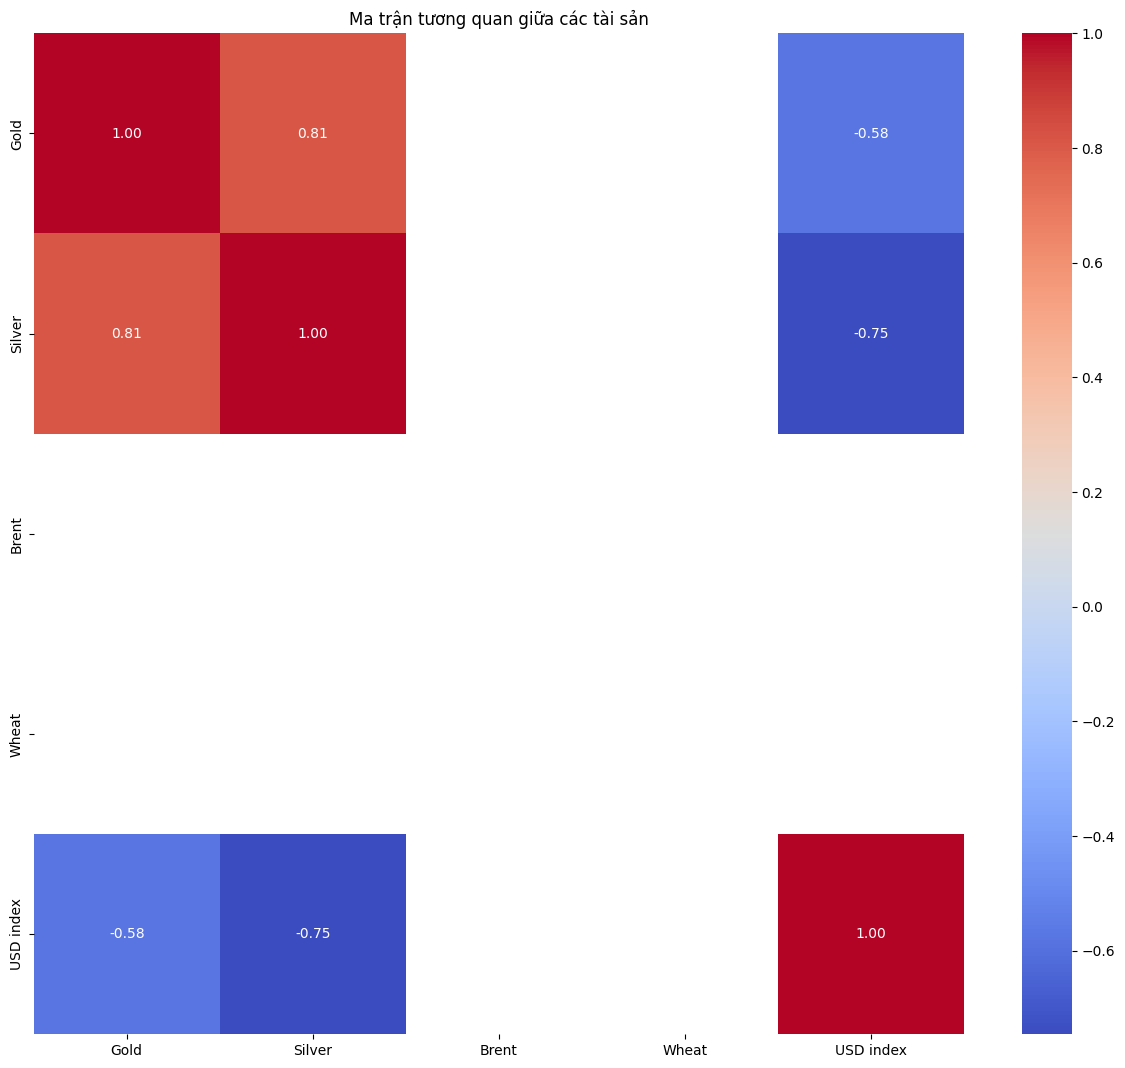

In [9]:
# 3. KIỂM TRA TƯƠNG QUAN (Bước này rất quan trọng để chứng minh Milk là thừa)
import seaborn as sns
plt.figure(figsize=(15, 13))
# Chỉ tính tương quan các cột giá gốc để xem
corr_matrix = df[features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Ma trận tương quan giữa các tài sản")
plt.show()

In [12]:
# 4. CHUẨN BỊ INPUT CHO XGBOOST
# Lấy tất cả cột Lag, MA, Vol làm đầu vào
input_cols = [c for c in df.columns if 'lag' in c or 'MA' in c or 'Vol' in c]
X = df[input_cols]
y = df[target]

# Chia Train/Test (80/20)
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [14]:
X_train

""
Datetime
2025-11-28 09:54:10
2025-11-28 09:54:20
2025-11-28 09:54:30
2025-11-28 09:54:40
2025-11-28 09:54:50
2025-11-28 09:55:00
2025-11-28 09:55:10
2025-11-28 09:55:20
2025-11-28 09:55:30
